<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_202401/blob/main/Modulo04/Modulo04_Classification.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Classification: Predicting Firm Exit

Our first task is to build a predictive model of the probability of a firm's default and therefore exit from business. 

In [1]:
options(warn=-1)

#install.packages("pacman") #if in colab
#Cargar librerías 
require("pacman")
p_load(tidyverse,
      caret,
      glmnet)


Loading required package: pacman



In [2]:
#Leer los datos 
db <- readRDS(url("https://github.com/ignaciomsarmiento/datasets/raw/main/bisnode_firms_clean.rds?raw=true"))
head(db)

year,comp_id,begin,end,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,⋯,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,default_f,sales_mil_log_sq,flag_low_d1_sales_mil_log,flag_high_d1_sales_mil_log,d1_sales_mil_log_mod,d1_sales_mil_log_mod_sq
<dbl>,<dbl>,<date>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2012,1001541,2012-01-01,2012-12-31,481.48148,9629.62988,1303.7037,0,0.000000,0.000000,⋯,0,1,0.6216911,1,no_default,45.19001681,1,0,-1.50000000,2.250000000
2012,1002029,2012-01-01,2012-12-31,14929.62988,203885.18750,120444.4531,0,0.000000,0.000000,⋯,0,1,0.4583333,0,no_default,0.01637541,0,0,0.68444822,0.468469365
2012,1003200,2012-01-01,2012-12-31,25.92593,22.22222,10996.2959,0,0.000000,0.000000,⋯,1,0,0.6216911,1,default,34.61487649,0,0,-1.42477311,2.029978407
2012,1011889,2012-01-01,2012-12-31,36625.92578,160166.67188,18911.1113,0,0.000000,0.000000,⋯,0,0,1.6212121,0,no_default,0.69802535,0,0,0.09772232,0.009549651
2012,1014183,2012-01-01,2012-12-31,12551.85156,199903.70312,8274.0742,0,7.407407,7.407407,⋯,0,0,0.7152778,0,no_default,4.17100049,0,0,-0.27308727,0.074576656
2012,1018301,2012-01-01,2012-12-31,0.00000,1811.11108,592.5926,0,11.111111,11.111111,⋯,0,0,0.1527778,0,no_default,25.02337045,0,0,-0.01910021,0.000364818





| Category       | Description                                                                                                                                                        |
|----------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Firm           | Age of firm, squared age, a dummy if newly established, industry categories, location regions for its headquarters, and dummy if located in a big city.        |
| Financial 1    | Winsorized financial variables: sales, fixed, liquid, current, intangible assets, current liabilities, inventories, equity shares, subscribed capital, sales revenues, income before tax, extra income, material, personal and extra expenditure, extra profit. |
| Financial 2    | Flags (extreme, low, high, zero – when applicable) and polynomials: quadratic terms are created for profit and loss, extra profit and loss, income before tax, and share equity.                                   |
| Growth         | Sales growth is captured by a winsorized growth variable, its quadratic term and flags for extreme low and high values.                                                                   |
| HR             | For the CEO: female dummy, winsorized age and flags, flag for missing information; foreign management dummy; labor cost, and flag for missing labor cost information.                                                |
| Data Quality   | Variables related to the data quality of the financial information, flag for a problem, and the length of the year that the balance sheet covers.                                                                     |
| Interactions   | Interactions with sales growth, firm size, and industry.                                                                                                                                   |



In [3]:
prop.table(table(db$default_f))*100


no_default    default 
  79.78567   20.21433 

In [4]:
prop.table(table(db$default))*100


       0        1 
79.78567 20.21433 

## Model variables
### Hand-Picked

In [5]:
X1 <- c("sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl", "ind2_cat")

### Hand-Picked + Firm specific

In [6]:
X2 <- c("sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl", "fixed_assets_bs","share_eq_bs","curr_liab_bs ",   "curr_liab_bs_flag_high ", "curr_liab_bs_flag_error",  "age","foreign_management" , "ind2_cat")


###  Firm specific + Financial + Lags

In [7]:
firm <- c("age", "age2", "new", "ind2_cat", "m_region_loc", "urban_m")

engvar <- c("total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl")

d1 <-  c("d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
         "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log")

In [8]:
X3 <- c("sales_mil_log", "sales_mil_log_sq", firm, engvar,                   d1)

###  All but interactions

In [9]:

engvar2 <- c("extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad")

engvar3 <- c(grep("*flag_low$", names(db), value = TRUE),
             grep("*flag_high$", names(db), value = TRUE),
             grep("*flag_error$", names(db), value = TRUE),
             grep("*flag_zero$", names(db), value = TRUE))

hr <- c("female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management")
qualityvars <- c("balsheet_flag", "balsheet_length", "balsheet_notfullyear")

In [10]:
X4 <- c("sales_mil_log", "sales_mil_log_sq", firm, engvar, engvar2, engvar3, d1, hr, qualityvars)

###  All 

In [11]:

# interactions
interactions1 <- c("ind2_cat*age", "ind2_cat*age2",
                   "ind2_cat*d1_sales_mil_log_mod", "ind2_cat*sales_mil_log",
                   "ind2_cat*ceo_age", "ind2_cat*foreign_management",
                   "ind2_cat*female",   "ind2_cat*urban_m", "ind2_cat*labor_avg_mod")
interactions2 <- c("sales_mil_log*age", "sales_mil_log*female",
                   "sales_mil_log*profit_loss_year_pl", "sales_mil_log*foreign_management")


In [12]:
X5 <- c("sales_mil_log", "sales_mil_log_sq", firm, engvar, engvar2, engvar3, d1, hr, qualityvars, interactions1, interactions2)

## Out of sample prediction

In [13]:
set.seed(13505)

train_indices <- as.integer(createDataPartition(db$default, p = 0.8, list = FALSE))
train <- db[train_indices, ]
test <- db[-train_indices, ]

dim(train)
dim(test)


[1] 15229   118

[1] 3807  118

### Logit

In [14]:
# 5 fold cross-validation
train_control <- trainControl(
  method = "cv",
  number = 5,
  classProbs = TRUE,
  summaryFunction = defaultSummary,
  savePredictions = TRUE
)


In [15]:
set.seed(13505)
glm_model_handpicked <- train(
    formula(paste0("default_f ~", paste0(X1, collapse = " + "))),
    method = "glm",
    data = train,
    family = "binomial",
    trControl = train_control
  )

In [16]:
glm_model_handpicked

Generalized Linear Model 

15229 samples
    5 predictor
    2 classes: 'no_default', 'default' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 12183, 12183, 12183, 12184, 12183 
Resampling results:

  Accuracy   Kappa    
  0.8072102  0.1644251


In [17]:
set.seed(13505)
glm_model_all <- train(
    formula(paste0("default_f ~", paste0(X4, collapse = " + "))),
    method = "glm",
    data = train,
    family = "binomial",
    trControl = train_control
  )

glm_model_all

Generalized Linear Model 

15229 samples
   71 predictor
    2 classes: 'no_default', 'default' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 12183, 12183, 12183, 12184, 12183 
Resampling results:

  Accuracy   Kappa    
  0.8179794  0.2802139


In [18]:
formula(paste0("default_f ~", paste0(X5, collapse = " + ")))

default_f ~ sales_mil_log + sales_mil_log_sq + age + age2 + new + 
    ind2_cat + m_region_loc + urban_m + total_assets_bs + fixed_assets_bs + 
    liq_assets_bs + curr_assets_bs + share_eq_bs + subscribed_cap_bs + 
    intang_assets_bs + extra_exp_pl + extra_inc_pl + extra_profit_loss_pl + 
    inc_bef_tax_pl + inventories_pl + material_exp_pl + profit_loss_year_pl + 
    personnel_exp_pl + extra_profit_loss_pl_quad + inc_bef_tax_pl_quad + 
    profit_loss_year_pl_quad + share_eq_bs_quad + extra_profit_loss_pl_flag_low + 
    inc_bef_tax_pl_flag_low + profit_loss_year_pl_flag_low + 
    share_eq_bs_flag_low + extra_exp_pl_flag_high + extra_inc_pl_flag_high + 
    inventories_pl_flag_high + material_exp_pl_flag_high + personnel_exp_pl_flag_high + 
    curr_liab_bs_flag_high + liq_assets_bs_flag_high + subscribed_cap_bs_flag_high + 
    extra_profit_loss_pl_flag_high + inc_bef_tax_pl_flag_high + 
    profit_loss_year_pl_flag_high + share_eq_bs_flag_high + extra_exp_pl_flag_error + 
    

In [19]:

lambda <- 10^seq(-1, -4, length = 100)
grid <- expand.grid("alpha" = 1, lambda = lambda)

set.seed(13505)
glm_model_lasso <- train(
    formula(paste0("default_f ~", paste0(X5, collapse = " + "))),
    method = "glmnet",
    data = train,
    family = "binomial",
    trControl = train_control,
    tuneGrid = grid,
    preProcess = c("center", "scale")
  )

glm_model_lasso

glmnet 

15229 samples
   71 predictor
    2 classes: 'no_default', 'default' 

Pre-processing: centered (153), scaled (153) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 12183, 12183, 12183, 12184, 12183 
Resampling results across tuning parameters:

  lambda        Accuracy   Kappa      
  0.0001000000  0.8198179  0.290493357
  0.0001072267  0.8198836  0.290638441
  0.0001149757  0.8198836  0.290405819
  0.0001232847  0.8196866  0.289501888
  0.0001321941  0.8195553  0.288971981
  0.0001417474  0.8195553  0.288975354
  0.0001519911  0.8195553  0.289208570
  0.0001629751  0.8194239  0.288466721
  0.0001747528  0.8194239  0.288697960
  0.0001873817  0.8194896  0.288623751
  0.0002009233  0.8194239  0.288268576
  0.0002154435  0.8193583  0.287675141
  0.0002310130  0.8192926  0.287301254
  0.0002477076  0.8194240  0.287609258
  0.0002656088  0.8196866  0.288415069
  0.0002848036  0.8195553  0.287692573
  0.0003053856  0.8197523  0.288348232
  0.0003274549  0.8200150  0

In [20]:
head(glm_model_handpicked$pred)

,pred,obs,no_default,default,rowIndex,parameter,Resample
,<fct>,<fct>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,no_default,no_default,0.9625133,0.03748667,3,none,Fold1
2,no_default,no_default,0.6878024,0.31219756,21,none,Fold1
3,no_default,no_default,0.7865239,0.21347614,25,none,Fold1
4,no_default,no_default,0.6722241,0.32777587,32,none,Fold1
5,no_default,no_default,0.8333391,0.16666093,33,none,Fold1
6,no_default,no_default,0.7849220,0.21507796,43,none,Fold1


In [21]:
confusionMatrix(data = glm_model_handpicked$pred$pred, 
                reference = glm_model_handpicked$pred$obs, 
                positive="default", mode = "prec_recall")

Confusion Matrix and Statistics

            Reference
Prediction   no_default default
  no_default      11850    2613
  default           323     443
                                          
               Accuracy : 0.8072          
                 95% CI : (0.8009, 0.8134)
    No Information Rate : 0.7993          
    P-Value [Acc > NIR] : 0.007595        
                                          
                  Kappa : 0.1646          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.57833         
                 Recall : 0.14496         
                     F1 : 0.23182         
             Prevalence : 0.20067         
         Detection Rate : 0.02909         
   Detection Prevalence : 0.05030         
      Balanced Accuracy : 0.55921         
                                          
       'Positive' Class : default         
                                

In [22]:
confusionMatrix(data = glm_model_all$pred$pred, reference = glm_model_all$pred$obs, positive="default", mode = "prec_recall")

Confusion Matrix and Statistics

            Reference
Prediction   no_default default
  no_default      11651    2250
  default           522     806
                                          
               Accuracy : 0.818           
                 95% CI : (0.8118, 0.8241)
    No Information Rate : 0.7993          
    P-Value [Acc > NIR] : 3.247e-09       
                                          
                  Kappa : 0.2802          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
              Precision : 0.60693         
                 Recall : 0.26374         
                     F1 : 0.36770         
             Prevalence : 0.20067         
         Detection Rate : 0.05293         
   Detection Prevalence : 0.08720         
      Balanced Accuracy : 0.61043         
                                          
       'Positive' Class : default         
                                

In [32]:
glm_model_all$pred$pred2<-factor(ifelse(glm_model_all$pred$default>=0.3,"default","no_default"),levels=c("default","no_default"))

In [ ]:
head(glm_model_all$pred)

In [33]:
confusionMatrix(data = glm_model_all$pred$pred2, reference = glm_model_all$pred$obs, positive="default", mode = "prec_recall")

Confusion Matrix and Statistics

            Reference
Prediction   no_default default
  no_default      10372    1475
  default          1801    1581
                                          
               Accuracy : 0.7849          
                 95% CI : (0.7783, 0.7914)
    No Information Rate : 0.7993          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3552          
                                          
 Mcnemar's Test P-Value : 1.361e-08       
                                          
              Precision : 0.4675          
                 Recall : 0.5173          
                     F1 : 0.4911          
             Prevalence : 0.2007          
         Detection Rate : 0.1038          
   Detection Prevalence : 0.2221          
      Balanced Accuracy : 0.6847          
                                          
       'Positive' Class : default         
                                

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Not averaging probs.

Group 1 type: cv

Observations: 15229

Number of groups: 1

Observations per group: 15229

Positive: default

Negative: no_default

Group: Group 1

Positive: 3056

Negative: 12173

***Performance Metrics***

Group 1 Optimal Informedness = 0.419795219916363

Group 1 AUC-ROC = 0.78



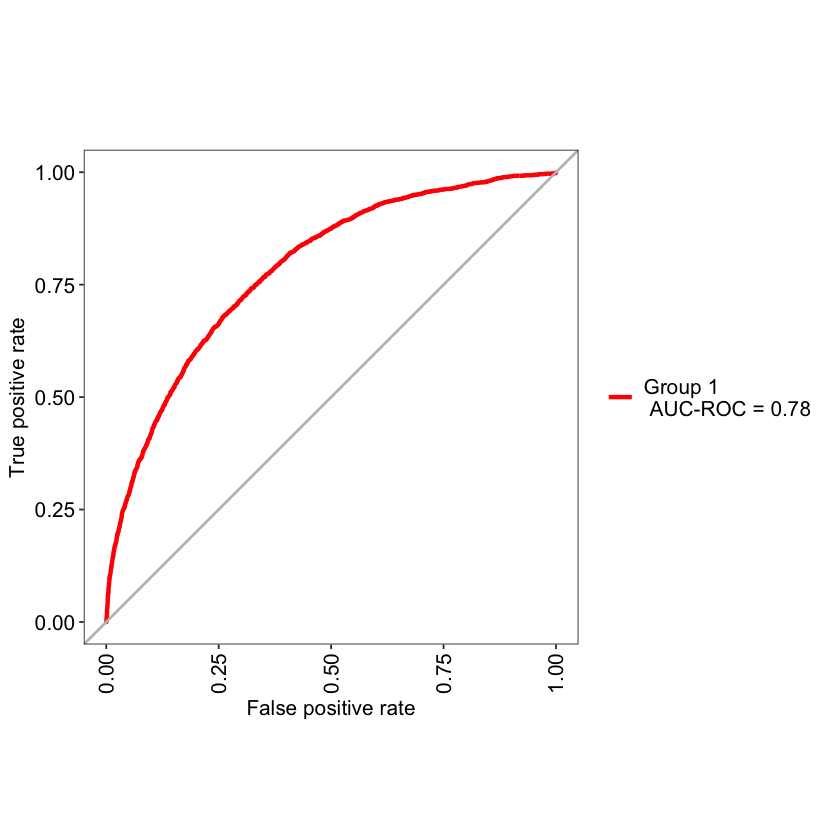

In [23]:
p_load("MLeval")

roc_glm_model_all <- evalm(glm_model_all,plots="r") #r Roc

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Not averaging probs.

Group 1 type: cv

Group 2 type: cv

Observations: 30458

Number of groups: 2

Observations per group: 15229

Positive: default

Negative: no_default

Group: Handpicked

Positive: 3056

Negative: 12173

Group: All

Positive: 3056

Negative: 12173

***Performance Metrics***

Handpicked Optimal Informedness = 0.359112094916094

All Optimal Informedness = 0.419795219916363

Handpicked AUC-ROC = 0.74

All AUC-ROC = 0.78



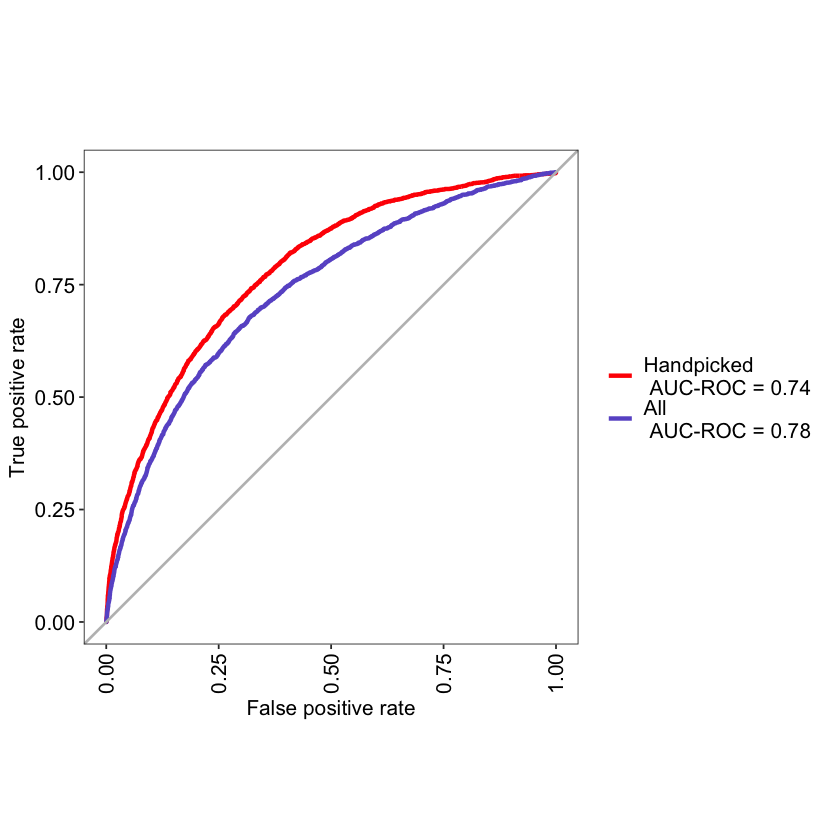

In [24]:
res_insample_all <- evalm(list(glm_model_handpicked, glm_model_all),gnames=c('Handpicked','All'),plots='r')

In [25]:
p_load(pROC)

In [27]:
?roc

In [28]:
roc_obj_handpicked<-roc(response=glm_model_handpicked$pred$obs,
                        predictor=glm_model_handpicked$pred$default)

roc_obj_all<-roc(response=glm_model_all$pred$obs,
                 predictor=glm_model_all$pred$default)

Setting levels: control = no_default, case = default

Setting direction: controls < cases

Setting levels: control = no_default, case = default

Setting direction: controls < cases



In [29]:
rfThresh <- coords(roc_obj_all, x = "best", best.method = "closest.topleft")
rfThresh

threshold,specificity,sensitivity
<dbl>,<dbl>,<dbl>
0.1899815,0.7038528,0.7146597


In [30]:
glm_model_all$pred$pred3<-factor(ifelse(glm_model_all$pred$default>=rfThresh$threshold,"default","no_default"),levels=c("default","no_default"))

In [35]:
confusionMatrix(data = glm_model_all$pred$pred3, reference = glm_model_all$pred$obs, positive="default", mode = "prec_recall")

Confusion Matrix and Statistics

            Reference
Prediction   no_default default
  no_default       8568     872
  default          3605    2184
                                          
               Accuracy : 0.706           
                 95% CI : (0.6987, 0.7133)
    No Information Rate : 0.7993          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3135          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.3773          
                 Recall : 0.7147          
                     F1 : 0.4938          
             Prevalence : 0.2007          
         Detection Rate : 0.1434          
   Detection Prevalence : 0.3801          
      Balanced Accuracy : 0.7093          
                                          
       'Positive' Class : default         
                                

## Model Tuning

In [39]:
multiStats <- function(...) c(twoClassSummary(...), defaultSummary(...), prSummary(...))

ctrl_multiStats<- trainControl(method = "cv",
                     number = 5,
                     summaryFunction = multiStats,
                     classProbs = TRUE,
                     verbose=FALSE,
                     savePredictions = T)

lambda <- 10^seq(-1, -4, length = 100)
grid <- expand.grid("alpha" = 1, lambda = lambda)

set.seed(13505)
glm_model_lasso_spec <- train(
    formula(paste0("default_f ~", paste0(X5, collapse = " + "))),
    method = "glmnet",
    data = train,
    family = "binomial",
    trControl = ctrl_multiStats,
    tuneGrid = grid,
    preProcess = c("center", "scale"),
     ## Specify which metric to optimize
    metric = "Spec"
  )

glm_model_lasso_spec

glmnet 

15229 samples
   71 predictor
    2 classes: 'no_default', 'default' 

Pre-processing: centered (153), scaled (153) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 12183, 12183, 12183, 12184, 12183 
Resampling results across tuning parameters:

  lambda        ROC        Sens       Spec         Accuracy   Kappa      
  0.0001000000  0.7827483  0.9571190  0.272912187  0.8198179  0.290493357
  0.0001072267  0.7828047  0.9572012  0.272912187  0.8198836  0.290638441
  0.0001149757  0.7828691  0.9572833  0.272585390  0.8198836  0.290405819
  0.0001232847  0.7829415  0.9572012  0.271931260  0.8196866  0.289501888
  0.0001321941  0.7830093  0.9571190  0.271604463  0.8195553  0.288971981
  0.0001417474  0.7831026  0.9571190  0.271603928  0.8195553  0.288975354
  0.0001519911  0.7831831  0.9570369  0.271930725  0.8195553  0.289208570
  0.0001629751  0.7832590  0.9570369  0.271276061  0.8194239  0.288466721
  0.0001747528  0.7833516  0.9569548  0.271603393  0.8194239  0.

## Alternative cutoffs

In [40]:
roc_obj_lasso<-roc(response=glm_model_lasso$pred$obs[glm_model_lasso$pred$lambda==glm_model_lasso$bestTune$lambda],
                   predictor=glm_model_lasso$pred$default[glm_model_lasso$pred$lambda==glm_model_lasso$bestTune$lambda])

Setting levels: control = no_default, case = default

Setting direction: controls < cases



In [41]:
rfThresh_lasso <- coords(roc_obj_lasso, x = "best", best.method = "closest.topleft")
rfThresh_lasso

threshold,specificity,sensitivity
<dbl>,<dbl>,<dbl>
0.1918555,0.7027849,0.7231675


In [42]:
pred_lasso<-factor(ifelse(glm_model_lasso$pred$default[glm_model_lasso$pred$lambda==glm_model_lasso$bestTune$lambda]>=rfThresh_lasso$threshold,
                          "default","no_default"),levels=c("default","no_default"))

In [43]:
confusionMatrix(data = pred_lasso, 
                reference = glm_model_lasso$pred$obs[glm_model_lasso$pred$lambda==glm_model_lasso$bestTune$lambda], 
                positive="default", mode = "prec_recall")

Confusion Matrix and Statistics

            Reference
Prediction   no_default default
  no_default       8555     846
  default          3618    2210
                                          
               Accuracy : 0.7069          
                 95% CI : (0.6996, 0.7141)
    No Information Rate : 0.7993          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.318           
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.3792          
                 Recall : 0.7232          
                     F1 : 0.4975          
             Prevalence : 0.2007          
         Detection Rate : 0.1451          
   Detection Prevalence : 0.3827          
      Balanced Accuracy : 0.7130          
                                          
       'Positive' Class : default         
                                

## Precision Recall Curve

In [44]:
prec_recall<-data.frame(coords(roc_obj_lasso, seq(0,1,length=100), ret=c("threshold", "precision", "recall")))

In [45]:
prec_recall<- prec_recall  %>% mutate(F1=(2*precision*recall)/(precision+recall))
prec_recall

threshold,precision,recall,F1
<dbl>,<dbl>,<dbl>,<dbl>
0.00000000,0.2006698,1.0000000,0.3342631
0.01010101,0.2013180,0.9996728,0.3351434
0.02020202,0.2051455,0.9967277,0.3402592
0.03030303,0.2133971,0.9934555,0.3513279
0.04040404,0.2238184,0.9839660,0.3646838
0.05050505,0.2344108,0.9705497,0.3776179
0.06060606,0.2466375,0.9600785,0.3924559
0.07070707,0.2583266,0.9466623,0.4058927
0.08080808,0.2724319,0.9329188,0.4217144


In [46]:
prec_recall$threshold[which.max(prec_recall$F1)]

[1] 0.2525253

In [47]:
pred_lasso_F1<-factor(ifelse(glm_model_lasso$pred$default[glm_model_lasso$pred$lambda==glm_model_lasso$bestTune$lambda]>=prec_recall$threshold[which.max(prec_recall$F1)],
                          "default","no_default"),levels=c("default","no_default"))

In [48]:
confusionMatrix(data = pred_lasso_F1, 
                reference = glm_model_lasso$pred$obs[glm_model_lasso$pred$lambda==glm_model_lasso$bestTune$lambda], 
                positive="default", mode = "prec_recall")

Confusion Matrix and Statistics

            Reference
Prediction   no_default default
  no_default       9710    1186
  default          2463    1870
                                          
               Accuracy : 0.7604          
                 95% CI : (0.7535, 0.7672)
    No Information Rate : 0.7993          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.3542          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.4316          
                 Recall : 0.6119          
                     F1 : 0.5062          
             Prevalence : 0.2007          
         Detection Rate : 0.1228          
   Detection Prevalence : 0.2845          
      Balanced Accuracy : 0.7048          
                                          
       'Positive' Class : default         
                                